<a href="https://colab.research.google.com/github/rajashre-e/Pollution_Prediction_AIML/blob/main/Pollution_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Quality Prediction Project — Delhi, Chennai, Pune (Open‑Meteo)

**Data Source:** [Open‑Meteo Air Quality API](https://open-meteo.com/en/docs/air-quality-api)  
**Geocoding:** [Open‑Meteo Geocoding API](https://open-meteo.com/en/docs/geocoding-api)

This notebook automatically:
1. Fetches **hourly air-quality** data for **Kolkata, Agartala, Dehradun and Puducherry** from **Aug 1, 2022** up to **2025-10-29** (maximum available per docs).
2. Performs **EDA** (descriptive stats, missingness, distributions, seasonal trends, correlations).
3. Runs **PCA** on daily pollutant features.
4. Trains a **RandomForest Regressor** to predict **next-day PM2.5** and visualizes results.
5. Applies **clustering** using both **KMeans** (Euclidean) and **Jaccard-based agglomerative** on binarized exceedance features.
6. Builds **GRU**, **LSTM**, and a simple **Transformer** for **time-series PM2.5 forecasting** per city.

> **Notes & Constraints**  
> • Open‑Meteo's Air Quality API provides global forecasts and archived data **from August 2022 onward**. For Europe, a reanalysis goes back to 2013, but **for India we use the global archive (Aug 2022→present)**.  
> • We request data in **local time** with `timezone=auto` and aggregate **hourly → daily** for modeling & speed.


In [ ]:
# @title Runtime Setup (installs & imports)
# If running in Google Colab, this cell installs dependencies not guaranteed to be preinstalled.
!pip -q install pandas numpy matplotlib scikit-learn scipy requests tqdm tensorflow

import os, math, json, time, itertools, warnings, random
from datetime import datetime, date, timedelta
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans, AgglomerativeClustering

from scipy.spatial.distance import pdist, squareform

import tensorflow as tf
from tensorflow.keras import layers, callbacks, models

warnings.filterwarnings('ignore')

print('TensorFlow:', tf.__version__)


TensorFlow: 2.19.0


In [ ]:
# @title Configuration
# CITIES = ['Kolkata', 'Agartala', 'Dehradun','Puducherry']  # you can add more
CITIES = ['Kolkata']  # you can add more

COUNTRY_CODE = 'IN'
START_DATE = '2021-08-01'  # earliest global CAMS archive per Open‑Meteo docs
END_DATE = str(date.today())

# Hourly variables to fetch (common core)
HOURLY_VARS = [
    'pm2_5','pm10','ozone','nitrogen_dioxide','sulphur_dioxide','carbon_monoxide'
    # Add more if you like (e.g., 'aerosol_optical_depth','dust','us_aqi')
]


TIMEZONE = 'auto'  # local time for each city

# For clustering (Jaccard), we will binarize features by 75th percentile
BIN_THRESHOLD_Q = 0.75

# Deep learning sequence length & training params
LOOKBACK_DAYS = 30
EPOCHS = 20
BATCH_SIZE = 64
VAL_SPLIT = 0.2
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


In [ ]:
# @title Geocoding helper (Open‑Meteo Geocoding API)
def geocode_city(name, country_code=''):
    url = 'https://geocoding-api.open-meteo.com/v1/search'
    params = {'name': name, 'count': 1}
    if country_code:
        params['country'] = country_code  # accepted alias is 'country' for country filter
        params['countryCode'] = country_code  # also try strict filter if supported
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()
    if data.get('results'):
        res = data['results'][0]
        return {
            'name': res['name'],
            'lat': res['latitude'],
            'lon': res['longitude'],
            'timezone': res.get('timezone', 'auto'),
            'admin1': res.get('admin1', ''),
            'country': res.get('country', ''),
        }
    else:
        raise ValueError(f'No geocoding results for {name} ({country_code})')

# Quick test
for city in CITIES:
    print(city, geocode_city(city, COUNTRY_CODE))


Kolkata {'name': 'Calcutta', 'lat': 22.56263, 'lon': 88.36304, 'timezone': 'Asia/Kolkata', 'admin1': 'West Bengal', 'country': 'India'}


In [ ]:
# @title Fetch Hourly Air Quality data (chunked by month)
def month_range(start_date, end_date):
    start = pd.to_datetime(start_date).date().replace(day=1)
    end = pd.to_datetime(end_date).date().replace(day=1)
    months = []
    cur = start
    while cur <= end:
        # compute month end
        if cur.month == 12:
            next_month = date(cur.year+1, 1, 1)
        else:
            next_month = date(cur.year, cur.month+1, 1)
        month_end = next_month - timedelta(days=1)
        # clip to end_date
        months.append((max(cur, pd.to_datetime(start_date).date()),
                       min(month_end, pd.to_datetime(end_date).date())))
        cur = next_month
    return months

def fetch_air_quality(lat, lon, start_date, end_date, hourly_vars, timezone='auto'):
    base = 'https://air-quality-api.open-meteo.com/v1/air-quality'
    out_frames = []
    for (s, e) in tqdm(month_range(start_date, end_date), desc='Months'):
        params = {
            'latitude': lat,
            'longitude': lon,
            'hourly': ','.join(hourly_vars),
            'start_date': s.isoformat(),
            'end_date': e.isoformat(),
            # Use UTC to avoid local-hour “padding” that can create NaN rows on 3-hour data
            'timezone': 'GMT',
            # Force the global domain for India (3-hourly availability from Aug 2022)
            'domains': 'cams_global',
        }
        r = requests.get(base, params=params, timeout=60)
        if r.status_code != 200:
            print('Request failed for', s, e, r.text)
            continue
        js = r.json()
        if 'hourly' not in js or 'time' not in js['hourly']:
            print('No hourly data keys for', s, e)
            continue
        df = pd.DataFrame(js['hourly'])
        df['time'] = pd.to_datetime(df['time'], utc=True)  # keep UTC for now
        out_frames.append(df)
        time.sleep(0.1)
    if out_frames:
        df_all = (pd.concat(out_frames, ignore_index=True)
                    .drop_duplicates(subset=['time'])
                    .sort_values('time')
                    .reset_index(drop=True))
        return df_all
    else:
        return pd.DataFrame()


# Collect for all cities
city_meta = {}
city_frames = []
for city in CITIES:
    info = geocode_city(city, COUNTRY_CODE)
    city_meta[city] = info
    print('Fetching', city, info)
    df_city = fetch_air_quality(info['lat'], info['lon'], START_DATE, END_DATE, HOURLY_VARS, TIMEZONE)
    if not df_city.empty:
        df_city['city'] = city
        city_frames.append(df_city)

raw_hourly = pd.concat(city_frames, ignore_index=True) if city_frames else pd.DataFrame()
print('Hourly shape:', raw_hourly.shape)
raw_hourly.head()


Fetching Kolkata {'name': 'Calcutta', 'lat': 22.56263, 'lon': 88.36304, 'timezone': 'Asia/Kolkata', 'admin1': 'West Bengal', 'country': 'India'}


Months: 100%|██████████| 52/52 [00:09<00:00,  5.49it/s]


Hourly shape: (37584, 8)


,time,pm2_5,pm10,ozone,nitrogen_dioxide,sulphur_dioxide,carbon_monoxide,city
0,2021-08-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Kolkata
1,2021-08-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Kolkata
2,2021-08-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Kolkata
3,2021-08-01 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Kolkata
4,2021-08-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,Kolkata


In [ ]:
# ---- Clean + Save Hourly ----
os.makedirs('data', exist_ok=True)

# Drop rows where ALL pollutants are NaN (e.g., padded hours that don't exist on the 3-hour grid)
hourly_clean = raw_hourly.copy()
for col in HOURLY_VARS:
    if col in hourly_clean.columns:
        hourly_clean[col] = pd.to_numeric(hourly_clean[col], errors='coerce')

hourly_clean = hourly_clean.dropna(how='all', subset=HOURLY_VARS)

# Save combined hourly
hourly_all_path = 'data/openmeteo_air_quality_hourly_all_cities.csv'
hourly_clean.to_csv(hourly_all_path, index=False)
print('Saved:', hourly_all_path)

# Save hourly per-city
for city in CITIES:
    p = f"data/openmeteo_air_quality_hourly_{city}.csv"
    hourly_clean[hourly_clean['city'] == city].to_csv(p, index=False)
    print('Saved:', p)

# ---- Build + Save Daily (mean of available timesteps) ----
daily = (
    hourly_clean
      .set_index('time')
      .groupby('city')
      .resample('D')[HOURLY_VARS]
      .mean()
      .reset_index()
      .dropna(how='all', subset=HOURLY_VARS)
)

daily_all_path = 'data/openmeteo_air_quality_daily_all_cities.csv'
daily.to_csv(daily_all_path, index=False)
print('Saved:', daily_all_path)

# Save daily per-city
for city in CITIES:
    p = f"data/openmeteo_air_quality_daily_{city}.csv"
    daily[daily['city'] == city].to_csv(p, index=False)
    print('Saved:', p)


Saved: data/openmeteo_air_quality_hourly_all_cities.csv
Saved: data/openmeteo_air_quality_hourly_Kolkata.csv
Saved: data/openmeteo_air_quality_daily_all_cities.csv
Saved: data/openmeteo_air_quality_daily_Kolkata.csv


In [ ]:
# @title Save raw and build daily dataset
os.makedirs('data', exist_ok=True)
raw_path = 'data/openmeteo_air_quality_hourly.csv'
raw_hourly.to_csv(raw_path, index=False)
print('Saved hourly to', raw_path)

# Minimal cleaning: ensure numeric dtypes
for col in HOURLY_VARS:
    if col in raw_hourly.columns:
        raw_hourly[col] = pd.to_numeric(raw_hourly[col], errors='coerce')

# Daily means per city (robust groupby+resample pattern)
daily = (
    raw_hourly
    .set_index('time')
    .groupby('city')
    .resample('D')[HOURLY_VARS]
    .mean()
    .reset_index()
    .dropna(how='all', subset=HOURLY_VARS)
)

daily_path = 'data/openmeteo_air_quality_daily.csv'
daily.to_csv(daily_path, index=False)
print('Saved daily to', daily_path)
daily.head()


Saved hourly to data/openmeteo_air_quality_hourly.csv
Saved daily to data/openmeteo_air_quality_daily.csv


,city,time,pm2_5,pm10,ozone,nitrogen_dioxide,sulphur_dioxide,carbon_monoxide
368,Kolkata,2022-08-04 00:00:00+00:00,17.012500,25.195833,22.958333,18.712500,20.237500,342.250000
369,Kolkata,2022-08-05 00:00:00+00:00,17.841667,26.375000,24.958333,24.554167,20.279167,420.500000
370,Kolkata,2022-08-06 00:00:00+00:00,14.687500,21.720833,24.541667,22.395833,19.858333,350.041667
371,Kolkata,2022-08-07 00:00:00+00:00,11.562500,17.600000,41.416667,16.941667,14.170833,283.958333
372,Kolkata,2022-08-08 00:00:00+00:00,9.341667,14.754167,51.708333,13.550000,11.554167,223.375000


## 1) Exploratory Data Analysis (EDA)

We explore coverage, missingness, distributions, and correlations per city on **daily** aggregates.


In [ ]:
# @title Coverage & basic stats
def describe_city(df_city):
    print('---', df_city['city'].iloc[0], '---')
    print('From', df_city['time'].min().date(), 'to', df_city['time'].max().date(), 'days:', df_city.shape[0])
    print(df_city[HOURLY_VARS].describe().T)

for city in CITIES:
    dcity = daily[daily['city'] == city].copy()
    if not dcity.empty:
        describe_city(dcity)


--- Kolkata ---
From 2022-08-04 to 2025-11-13 days: 1198
                   count        mean         std        min         25%  \
pm2_5             1198.0   56.479341   42.929365   0.675000   22.256250   
pm10              1198.0   76.736338   56.669664   0.970833   31.182292   
ozone             1198.0   83.288676   24.886297  16.333333   65.145833   
nitrogen_dioxide  1198.0   24.712733   25.458663   0.000000    8.361458   
sulphur_dioxide   1198.0   22.113422   15.829680   0.250000    9.754167   
carbon_monoxide   1198.0  660.592063  516.418723  59.583333  306.093750   

                         50%         75%          max  
pm2_5              43.610417   80.289583   262.483333  
pm10               61.114583  110.026042   345.245833  
ozone              81.812500  101.656250   151.291667  
nitrogen_dioxide   16.012500   28.341667   136.075000  
sulphur_dioxide    17.456250   30.408333    91.675000  
carbon_monoxide   500.770833  830.083333  3174.083333  


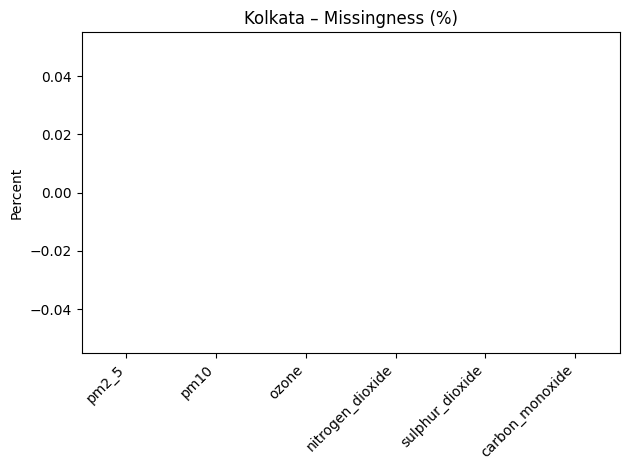

In [ ]:
# @title Missingness (% per feature) per city
for city in CITIES:
    dcity = daily[daily['city'] == city].copy()
    if dcity.empty:
        continue
    miss = dcity[HOURLY_VARS].isna().mean()*100
    plt.figure()
    miss.sort_values(ascending=False).plot(kind='bar')
    plt.title(f'{city} – Missingness (%)')
    plt.ylabel('Percent')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


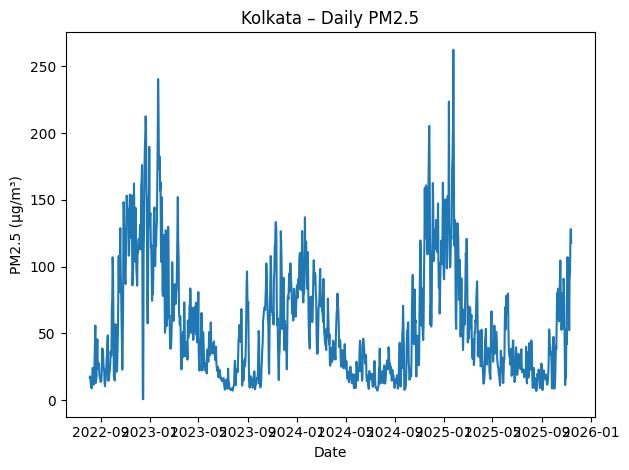

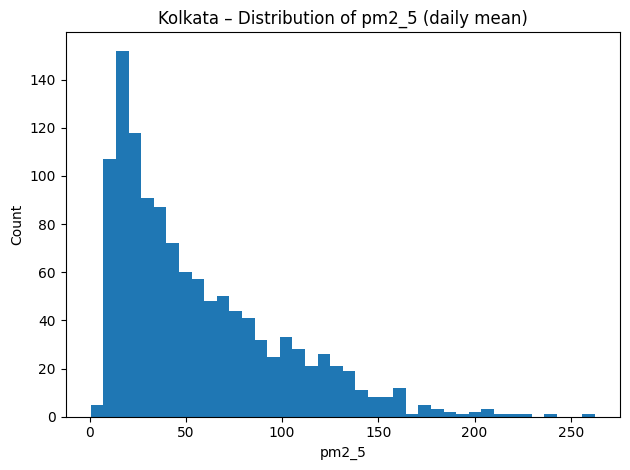

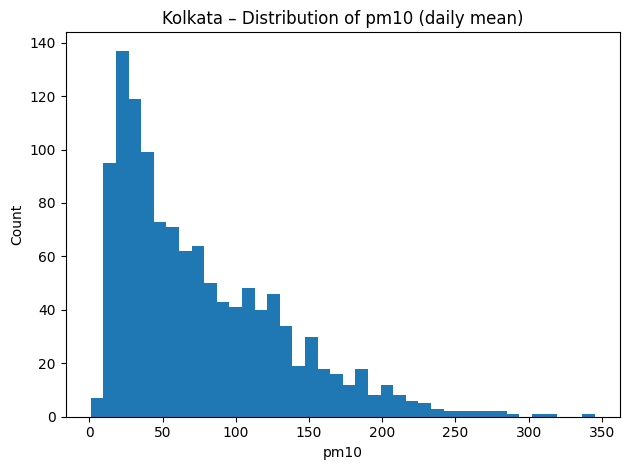

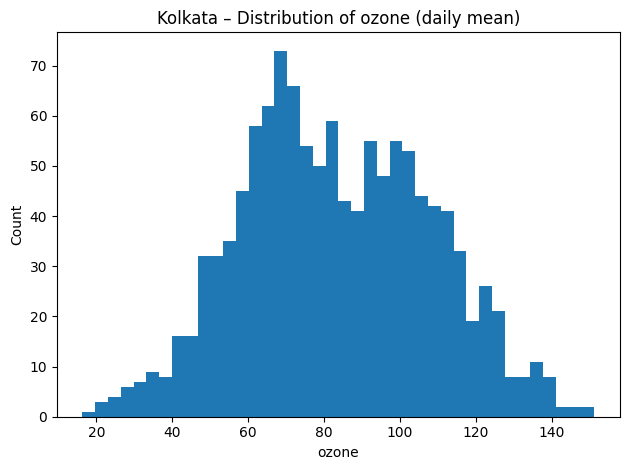

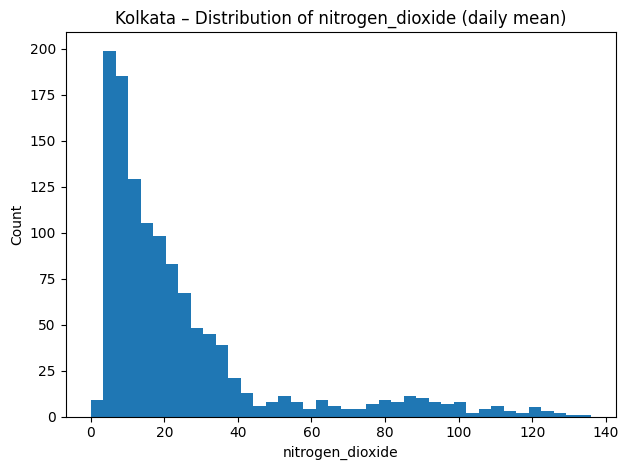

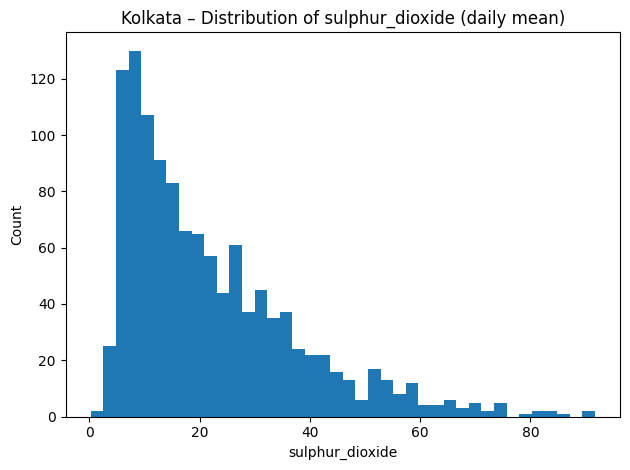

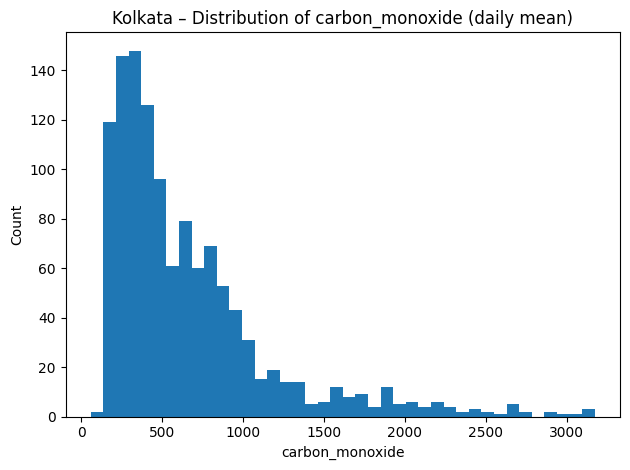

In [ ]:
# @title Distributions & time series (per city)
for city in CITIES:
    dcity = daily[daily['city'] == city].dropna(subset=['pm2_5']).copy()
    if dcity.empty:
        continue

    # PM2.5 daily time series
    plt.figure()
    plt.plot(pd.to_datetime(dcity['time']), dcity['pm2_5'])
    plt.title(f'{city} – Daily PM2.5')
    plt.xlabel('Date')
    plt.ylabel('PM2.5 (μg/m³)')
    plt.tight_layout()
    plt.show()

    # Histograms for pollutants
    for col in HOURLY_VARS:
        if col not in dcity.columns:
            continue
        series = dcity[col].dropna()
        if series.empty:
            continue
        plt.figure()
        plt.hist(series, bins=40)
        plt.title(f'{city} – Distribution of {col} (daily mean)')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()


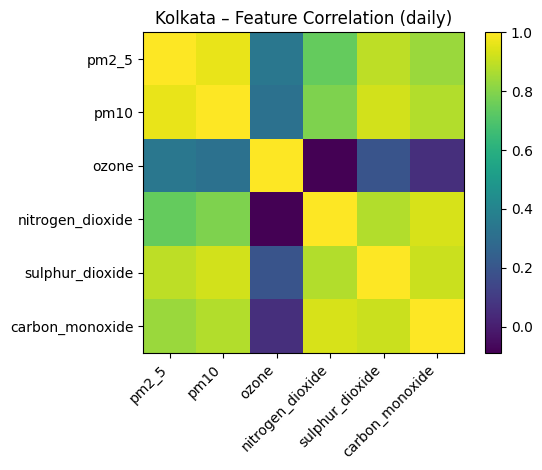

In [ ]:
# @title Correlation matrices (per city)
def plot_corr(df, title):
    corr = df[HOURLY_VARS].corr()
    plt.figure()
    im = plt.imshow(corr.values, interpolation='none')
    plt.title(title)
    plt.xticks(range(len(HOURLY_VARS)), HOURLY_VARS, rotation=45, ha='right')
    plt.yticks(range(len(HOURLY_VARS)), HOURLY_VARS)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

for city in CITIES:
    dcity = daily[daily['city'] == city].dropna().copy()
    if not dcity.empty:
        plot_corr(dcity, f'{city} – Feature Correlation (daily)')


## 2) PCA — Principal Component Analysis

We standardize daily pollutant features per city and compute PCA to identify dominant variance directions and loadings.


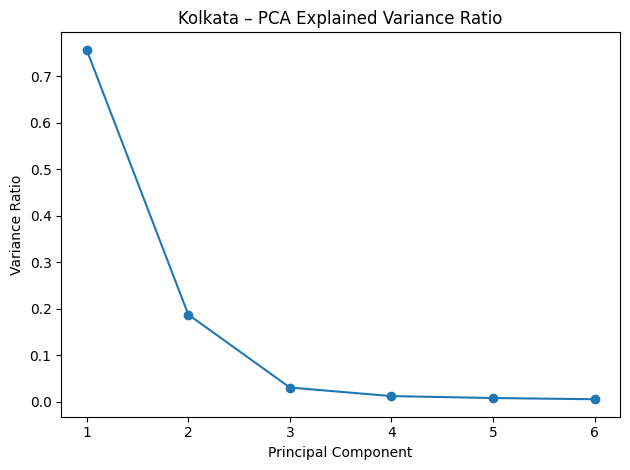

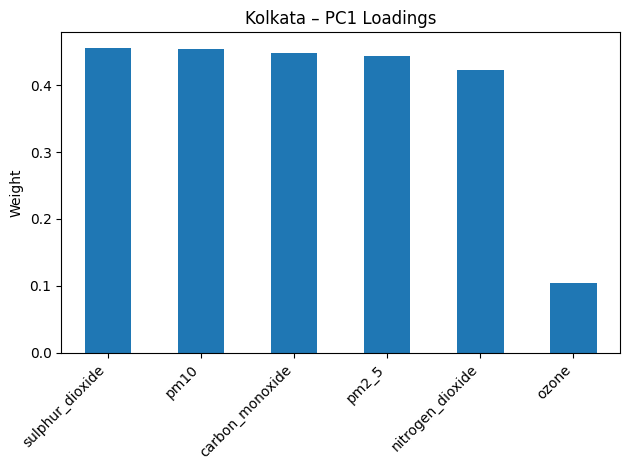

In [ ]:
# @title PCA per city
def run_pca(df, features):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[features].values)
    pca = PCA(n_components=min(6, X.shape[1]))
    Xp = pca.fit_transform(X)
    return pca, scaler, Xp

for city in CITIES:
    dcity = daily[daily['city'] == city].dropna().copy()
    if dcity.empty:
        continue
    pca, scaler, Xp = run_pca(dcity, HOURLY_VARS)
    # Scree plot
    plt.figure()
    plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
    plt.title(f'{city} – PCA Explained Variance Ratio')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Ratio')
    plt.tight_layout()
    plt.show()

    # Top loadings for PC1
    loadings = pd.Series(pca.components_[0], index=HOURLY_VARS).sort_values(ascending=False)
    plt.figure()
    loadings.plot(kind='bar')
    plt.title(f'{city} – PC1 Loadings')
    plt.ylabel('Weight')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 75: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 85: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 92: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


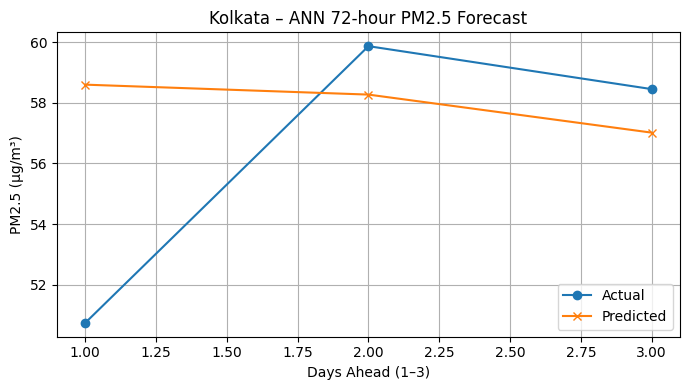


✅ ANN 72-hour Forecast Results:
            MAE    RMSE     R2
Kolkata  15.983  19.187  0.357


In [ ]:
import pandas as pd, numpy as np, math, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# --- Modified supervised creator for 72-hour (3-day) forecast ---
def make_supervised(df, target='pm2_5', lags=[1,2,3,7], horizons=[1,2,3]):
    df = df.sort_values('time').copy()
    for col in HOURLY_VARS:
        for L in lags:
            df[f'{col}_lag{L}'] = df[col].shift(L)
    # Create t+1, t+2, t+3 targets (next 72 hours)
    for h in horizons:
        df[f'{target}_tplus{h}'] = df[target].shift(-h)
    df = df.dropna().reset_index(drop=True)
    return df

# --- Evaluation ---
def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# --- Results dict ---
ann_results = {}

for city in CITIES:
    dcity = daily[daily['city'] == city].copy()
    if dcity.empty:
        continue

    # Prepare 72-hour supervised data
    df_sup = make_supervised(dcity, target='pm2_5')

    # ✅ Include target (current day's PM2.5) in features too
    feature_cols = ['pm2_5'] + [
        c for c in df_sup.columns
        if any(x in c for x in HOURLY_VARS) and c.endswith(tuple([f'_lag{L}' for L in [1,2,3,7]]))
    ]

    target_cols = [f'pm2_5_tplus{h}' for h in [1,2,3]]  # next 72 hours

    # Split
    n = len(df_sup)
    split = int(n * 0.8)
    X_train = df_sup.loc[:split-1, feature_cols].values
    y_train = df_sup.loc[:split-1, target_cols].values
    X_test  = df_sup.loc[split:, feature_cols].values
    y_test  = df_sup.loc[split:, target_cols].values

    # --- Enhanced ANN model ---
    model = Sequential([
        InputLayer(input_shape=(len(feature_cols),)),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(3)  # outputs t+1, t+2, t+3
    ])

    model.compile(optimizer=Adam(learning_rate=5e-4), loss='mse')

    es = EarlyStopping(patience=20, restore_best_weights=True)
    lr = ReduceLROnPlateau(factor=0.5, patience=7, verbose=1)

    # Train
    model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=400,
        batch_size=32,
        callbacks=[es, lr],
        verbose=0
    )

    # Predict and evaluate
    pred = model.predict(X_test)
    metrics = evaluate_regression(y_test.flatten(), pred.flatten())
    ann_results[city] = metrics

    # Plot one example (3-day forecast)
    plt.figure(figsize=(7,4))
    plt.plot(range(1,4), y_test[0], marker='o', label='Actual')
    plt.plot(range(1,4), pred[0], marker='x', label='Predicted')
    plt.title(f'{city} – ANN 72-hour PM2.5 Forecast')
    plt.xlabel('Days Ahead (1–3)')
    plt.ylabel('PM2.5 (μg/m³)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Final results table ---
print("\n✅ ANN 72-hour Forecast Results:")
print(pd.DataFrame(ann_results).T.round(3))


## 3) Supervised Learning — RandomForest (Predict next‑day PM2.5)

We create **lag features** from daily pollutants and predict **PM2.5 (t+1 day)**.  
Train/validation/test split is time‑ordered (80/20 split for hold‑out).

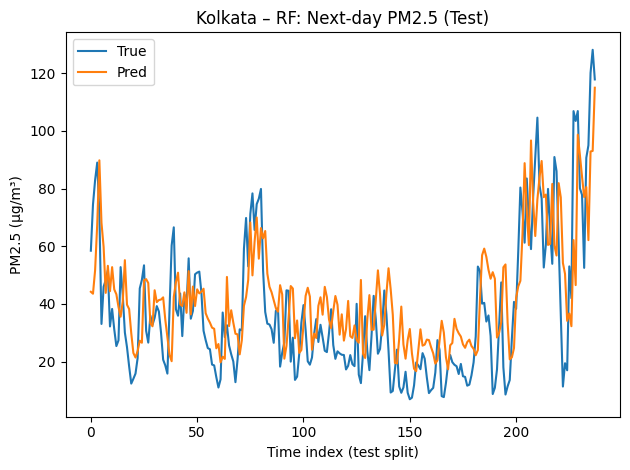

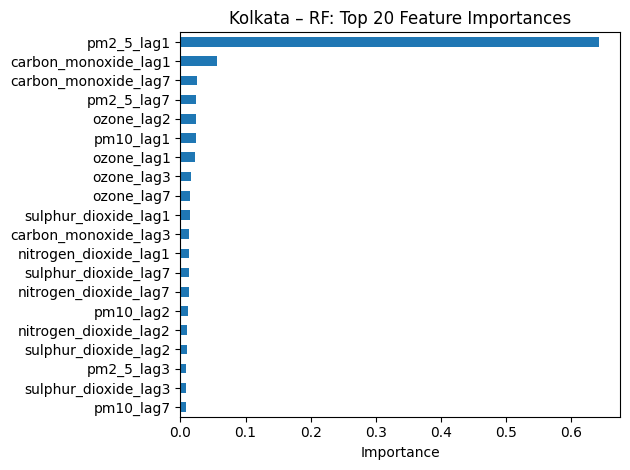

,MAE,RMSE,MAPE%
Kolkata,14.675157,17.938582,63.518436


In [ ]:
# @title Feature engineering for next-day PM2.5
def make_supervised(df, target='pm2_5', lags=[1,2,3,7]):
    df = df.sort_values('time').copy()
    for col in HOURLY_VARS:
        for L in lags:
            df[f'{col}_lag{L}'] = df[col].shift(L)
    # Target (t+1)
    df[f'{target}_tplus1'] = df[target].shift(-1)
    df = df.dropna().reset_index(drop=True)
    return df

def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(1e-6, np.abs(y_true)))) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE%': mape}

rf_results = {}

for city in CITIES:
    dcity = daily[daily['city'] == city].copy()
    if dcity.empty:
        continue
    df_sup = make_supervised(dcity, target='pm2_5')
    feature_cols = [c for c in df_sup.columns if any(x in c for x in HOURLY_VARS) and c.endswith(tuple([f'_lag{L}' for L in [1,2,3,7]]))]

    # time-based split
    n = len(df_sup)
    split = int(n*0.8)
    X_train = df_sup.loc[:split-1, feature_cols].values
    y_train = df_sup.loc[:split-1, 'pm2_5_tplus1'].values
    X_test  = df_sup.loc[split:, feature_cols].values
    y_test  = df_sup.loc[split:, 'pm2_5_tplus1'].values

    # scale features (optional for tree models; we keep raw)
    rf = RandomForestRegressor(n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)

    metrics = evaluate_regression(y_test, pred)
    rf_results[city] = metrics

    # Plots
    plt.figure()
    plt.plot(range(len(y_test)), y_test, label='True')
    plt.plot(range(len(pred)), pred, label='Pred')
    plt.title(f'{city} – RF: Next-day PM2.5 (Test)')
    plt.xlabel('Time index (test split)')
    plt.ylabel('PM2.5 (μg/m³)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Feature importance
    importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)[:20]
    plt.figure()
    importances[::-1].plot(kind='barh')
    plt.title(f'{city} – RF: Top 20 Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

pd.DataFrame(rf_results).T


## 4) Clustering

We demonstrate two approaches:

1. **KMeans** on standardized numeric daily features (Euclidean distance).  
2. **Agglomerative clustering with precomputed *Jaccard distance*** on **binarized exceedance features** (e.g., values above the 75th percentile marked as 1).  

> **Why not Jaccard with KMeans?** KMeans optimizes Euclidean distances and **is not compatible** with Jaccard similarity. To use Jaccard, we use agglomerative clustering on a precomputed Jaccard distance matrix.


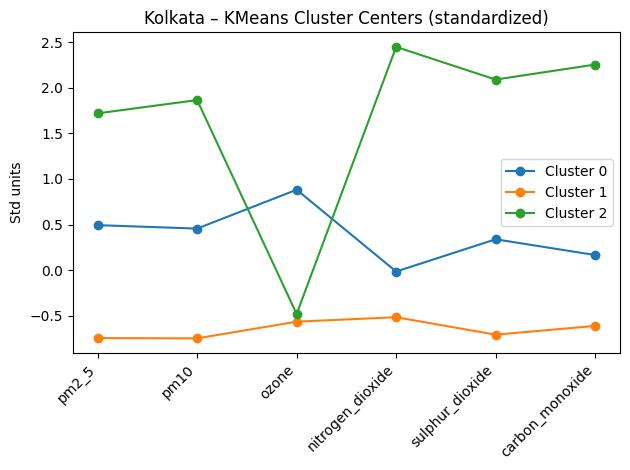

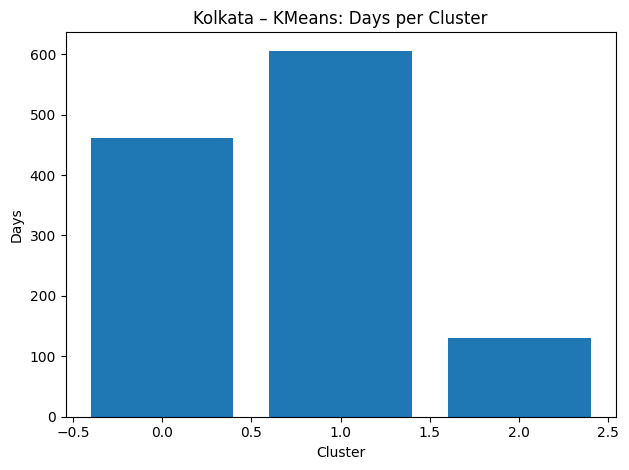

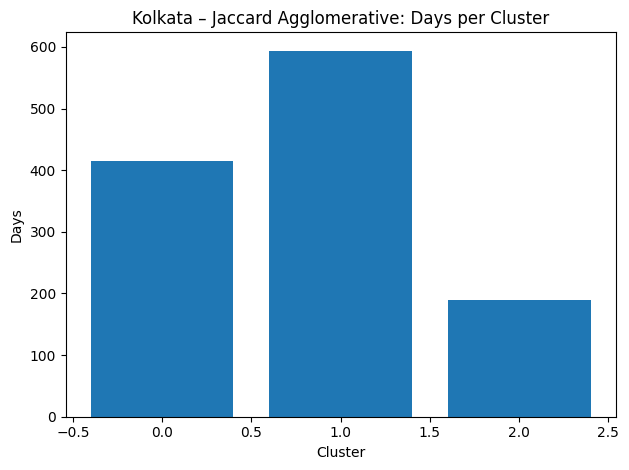

In [ ]:
# @title KMeans (Euclidean) and Jaccard-based Agglomerative
CLUSTERS = 3

for city in CITIES:
    dcity = daily[daily['city'] == city].dropna().copy()
    if len(dcity) < 30:  # need some data
        continue

    # ----- KMeans on standardized numeric features -----
    X = dcity[HOURLY_VARS].values
    Xs = StandardScaler().fit_transform(X)
    km = KMeans(n_clusters=CLUSTERS, n_init=10, random_state=RANDOM_SEED)
    labels_km = km.fit_predict(Xs)
    dcity['kmeans_cluster'] = labels_km

    plt.figure()
    for k in range(CLUSTERS):
        center = km.cluster_centers_[k]
        plt.plot(range(len(HOURLY_VARS)), center, marker='o', label=f'Cluster {k}')
    plt.title(f'{city} – KMeans Cluster Centers (standardized)')
    plt.xticks(range(len(HOURLY_VARS)), HOURLY_VARS, rotation=45, ha='right')
    plt.ylabel('Std units')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ----- Jaccard on binarized exceedances + Agglomerative -----
    bin_df = dcity[HOURLY_VARS].copy()
    thr = bin_df.quantile(BIN_THRESHOLD_Q)  # per feature threshold
    bin_df = (bin_df.ge(thr)).astype(int)

    # Jaccard distance on rows (days)
    D = squareform(pdist(bin_df.values, metric='jaccard'))
    agg = AgglomerativeClustering(n_clusters=CLUSTERS, metric='precomputed', linkage='average')
    labels_j = agg.fit_predict(D)
    dcity['jaccard_cluster'] = labels_j

    # Plot cluster counts
    cnt_km = dcity['kmeans_cluster'].value_counts().sort_index()
    cnt_j  = dcity['jaccard_cluster'].value_counts().sort_index()

    plt.figure()
    plt.bar(range(CLUSTERS), cnt_km.values)
    plt.title(f'{city} – KMeans: Days per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Days')
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.bar(range(CLUSTERS), cnt_j.values)
    plt.title(f'{city} – Jaccard Agglomerative: Days per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Days')
    plt.tight_layout()
    plt.show()


## 5) Deep Learning — GRU, LSTM, Transformer (Daily PM2.5 Forecast)

We create supervised sequences of **LOOKBACK_DAYS → next‑day PM2.5** per city, split into train/val/test in time order, and train:
- **GRU**
- **LSTM**
- **Transformer (simple encoder)**

Metrics: MSE/MAE on test split, and prediction plots.


In [ ]:
# @title Prepare sequences
def build_sequences(series, lookback=30):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    X = np.array(X)[:, :, None]  # (N, lookback, 1)
    y = np.array(y)
    return X, y

def train_val_test_split_time(X, y, val_split=0.2, test_split=0.1):
    n = len(X)
    n_test = int(n * test_split)
    n_val = int(n * val_split)
    n_train = n - n_val - n_test
    X_tr, y_tr = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_te, y_te = X[n_train+n_val:], y[n_train+n_val:]
    return (X_tr, y_tr), (X_val, y_val), (X_te, y_te)

def scale_series(arr):
    m = np.nanmean(arr)
    s = np.nanstd(arr) + 1e-6
    return (arr - m) / s, m, s

def inverse_scale(arr, m, s):
    return arr * s + m

def plot_pred(true, pred, title):
    plt.figure()
    plt.plot(range(len(true)), true, label='True')
    plt.plot(range(len(pred)), pred, label='Pred')
    plt.title(title)
    plt.xlabel('Time index (test split)')
    plt.ylabel('PM2.5 (μg/m³)')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# --- Replace your previous "Model builders" cell with this ---

from tensorflow.keras import layers, models

def build_gru(input_shape):
    i = layers.Input(shape=input_shape)          # (steps, 1)
    x = layers.GRU(64)(i)
    x = layers.Dense(64, activation='relu')(x)
    o = layers.Dense(1)(x)
    model = models.Model(i, o)
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    i = layers.Input(shape=input_shape)          # (steps, 1)
    x = layers.LSTM(64)(i)
    x = layers.Dense(64, activation='relu')(x)
    o = layers.Dense(1)(x)
    model = models.Model(i, o)
    model.compile(optimizer='adam', loss='mse')
    return model

# ---- Clean Transformer pieces (no Lambda shape issues) ----
class PositionalEmbedding(layers.Layer):
    """Projects scalar input to `embed_dim` and adds learned positional vectors."""
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.proj = layers.Dense(embed_dim)
        self.embed_dim = embed_dim
        # Use a generous maximum length; we only index [0:sequence_len) at runtime.
        self.pos_emb = layers.Embedding(input_dim=1000, output_dim=embed_dim)

    def call(self, x):
        # x: (batch, steps, 1)
        batch = tf.shape(x)[0]
        steps = tf.shape(x)[1]
        # [steps]
        positions = tf.range(start=0, limit=steps, delta=1)
        # (steps, embed_dim)
        pos = self.pos_emb(positions)
        # (batch, steps, embed_dim) via broadcasting
        x_proj = self.proj(x)
        return x_proj + pos

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads=4, ff_dim=128, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = layers.Dropout(dropout)
        self.drop2 = layers.Dropout(dropout)

    def call(self, x, training=False):
        attn_out = self.att(x, x)          # self-attention
        attn_out = self.drop1(attn_out, training=training)
        out1 = self.norm1(x + attn_out)
        ffn_out = self.ffn(out1)
        ffn_out = self.drop2(ffn_out, training=training)
        return self.norm2(out1 + ffn_out)

def build_transformer_encoder(input_shape, heads=4, embed_dim=32, ff_dim=128, dropout=0.1):
    """Simple encoder-only Transformer for 1D sequences."""
    i = layers.Input(shape=input_shape)     # (steps, 1)
    x = PositionalEmbedding(embed_dim=embed_dim)(i)
    x = TransformerBlock(embed_dim=embed_dim, num_heads=heads, ff_dim=ff_dim, dropout=dropout)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    o = layers.Dense(1)(x)
    model = models.Model(i, o)
    model.compile(optimizer='adam', loss='mse')
    return model


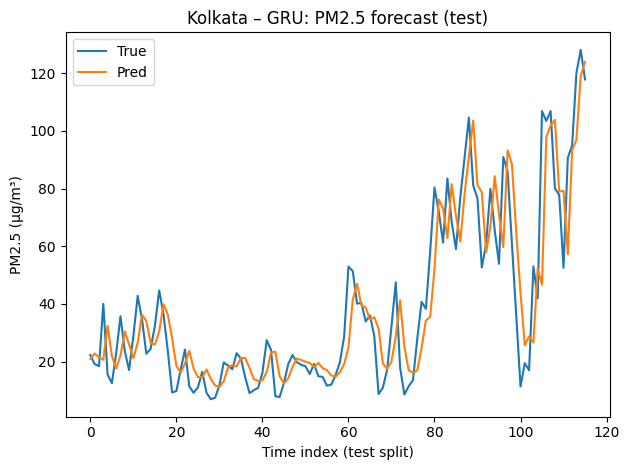

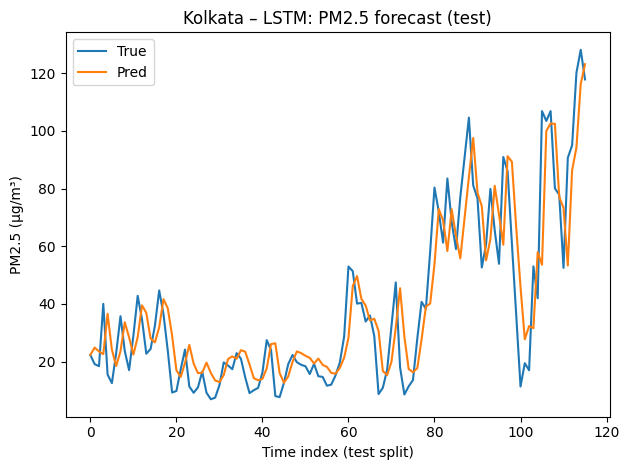

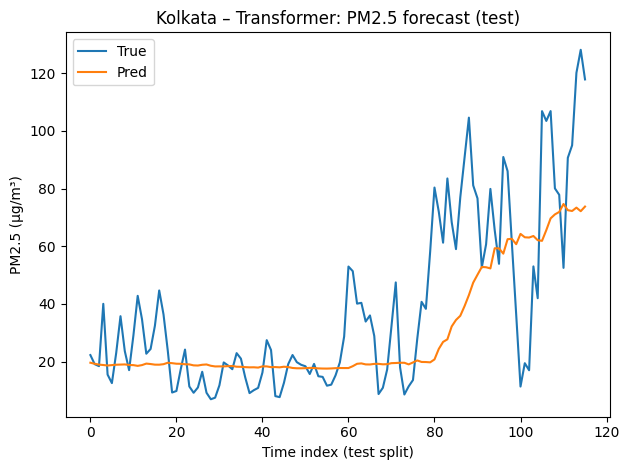

,GRU_MAE,LSTM_MAE,Transformer_MAE
Kolkata,10.365088,10.610718,15.920782


In [ ]:
# @title Train & evaluate DL per city
from keras import layers, models
dl_scores = {}

for city in CITIES:
    dcity = daily[daily['city'] == city].dropna(subset=['pm2_5']).copy()
    if len(dcity) < 200:
        print(f'{city}: not enough daily points for DL, skipping.')
        continue

    series = dcity['pm2_5'].values.astype(float)
    series_scaled, m, s = scale_series(series)
    X, y = build_sequences(series_scaled, lookback=LOOKBACK_DAYS)
    (X_tr, y_tr), (X_val, y_val), (X_te, y_te) = train_val_test_split_time(X, y, val_split=VAL_SPLIT, test_split=0.1)

    input_shape = X_tr.shape[1:]

    es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # GRU
    gru = build_gru(input_shape)
    gru.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])
    p_gru = gru.predict(X_te, verbose=0).ravel()
    p_gru = inverse_scale(p_gru, m, s)
    y_true = inverse_scale(y_te, m, s)
    mae_gru = mean_absolute_error(y_true, p_gru)

    plot_pred(y_true, p_gru, f'{city} – GRU: PM2.5 forecast (test)')

    # LSTM
    lstm = build_lstm(input_shape)
    lstm.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])
    p_lstm = lstm.predict(X_te, verbose=0).ravel()
    p_lstm = inverse_scale(p_lstm, m, s)
    mae_lstm = mean_absolute_error(y_true, p_lstm)

    plot_pred(y_true, p_lstm, f'{city} – LSTM: PM2.5 forecast (test)')

    # Transformer
    trf = build_transformer_encoder(input_shape)
    trf.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])
    p_trf = trf.predict(X_te, verbose=0).ravel()
    p_trf = inverse_scale(p_trf, m, s)
    mae_trf = mean_absolute_error(y_true, p_trf)

    plot_pred(y_true, p_trf, f'{city} – Transformer: PM2.5 forecast (test)')

    dl_scores[city] = {'GRU_MAE': mae_gru, 'LSTM_MAE': mae_lstm, 'Transformer_MAE': mae_trf}

pd.DataFrame(dl_scores).T


### Outputs
- `/content/data/openmeteo_air_quality_hourly.csv` — Hourly air-quality for all cities
- `/content/data/openmeteo_air_quality_daily.csv` — Daily means used for modeling

You can export figures from Colab (File → Print/Save) as needed.


In [ ]:
# @title City metadata used
pd.DataFrame(city_meta).T

,name,lat,lon,timezone,admin1,country
Kolkata,Calcutta,22.56263,88.36304,Asia/Kolkata,West Bengal,India
Agartala,Agartala,23.83605,91.27939,Asia/Kolkata,Tripura,India
Dehradun,Dehradun,30.32443,78.03392,Asia/Kolkata,Uttarakhand,India
Puducherry,Puducherry,11.93381,79.82979,Asia/Kolkata,Puducherry,India
